In [1]:
# Build the CNN+Transformer model
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Model construction
embed_dim = 128  # Embedding size for each token
num_heads = 4    # Number of attention heads
ff_dim = 128     # Hidden layer size in feed-forward network

In [2]:
# Set the data path
data_path = 'C:/Users/USER/Desktop/프보기/preprocessed'

# Load data
def load_data(data_path):
    data = []
    labels = []
    
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path) and folder.endswith('_walk_3'):
            # Read accelerometer and gyroscope data
            acc_path = os.path.join(folder_path, 'Accelerometer.csv')
            gyro_path = os.path.join(folder_path, 'Gyroscope.csv')
            
            if os.path.exists(acc_path) and os.path.exists(gyro_path):
                acc_data = pd.read_csv(acc_path)[['x', 'y', 'z']].values  # Extract XYZ columns
                gyro_data = pd.read_csv(gyro_path)[['x', 'y', 'z']].values  # Extract XYZ columns
                
                # Ensure both data arrays have the same number of rows
                min_length = min(len(acc_data), len(gyro_data))
                acc_data = acc_data[:min_length]
                gyro_data = gyro_data[:min_length]
                
                # Concatenate accelerometer and gyroscope data
                combined_data = np.hstack((acc_data, gyro_data))
                
                # Apply sliding window technique to generate more samples
                window_size = 100
                step_size = 50
                for start in range(0, len(combined_data) - window_size + 1, step_size):
                    window_data = combined_data[start:start + window_size]
                    data.append(window_data)
                    labels.append(folder.split('_')[0])
    
    return data, labels

# Prepare the data
data, labels = load_data(data_path)

# Pad sequences to the same length (if necessary)
max_length = max([len(d) for d in data])
data = [np.pad(d, ((0, max_length - len(d)), (0, 0)), 'constant') if len(d) < max_length else d for d in data]
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

In [3]:
model_cnn_transformer = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(max_length, data.shape[2])),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    TransformerBlock(embed_dim=128, num_heads=num_heads, ff_dim=ff_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model_cnn_transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_transformer = model_cnn_transformer.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Evaluate the model
y_pred_cnn_transformer = model_cnn_transformer.predict(X_test)
y_pred_classes_cnn_transformer = np.argmax(y_pred_cnn_transformer, axis=1)


Epoch 1/50
28/28 [==============================] - 2s 13ms/step - loss: 2.8002 - accuracy: 0.1224 - val_loss: 2.4973 - val_accuracy: 0.1224
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 2.2188 - accuracy: 0.2841 - val_loss: 1.6786 - val_accuracy: 0.4490
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 1.5905 - accuracy: 0.4688 - val_loss: 0.8787 - val_accuracy: 0.7551
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.9674 - accuracy: 0.6952 - val_loss: 0.6662 - val_accuracy: 0.7959
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 0.5397 - accuracy: 0.8291 - val_loss: 0.5101 - val_accuracy: 0.8571
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.4115 - accuracy: 0.8776 - val_loss: 0.3874 - val_accuracy: 0.8776
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2730 - accuracy: 0.9192 - val_loss: 0.3104 - val_accuracy: 0.8980
Epoch 8/50
28/28 [=

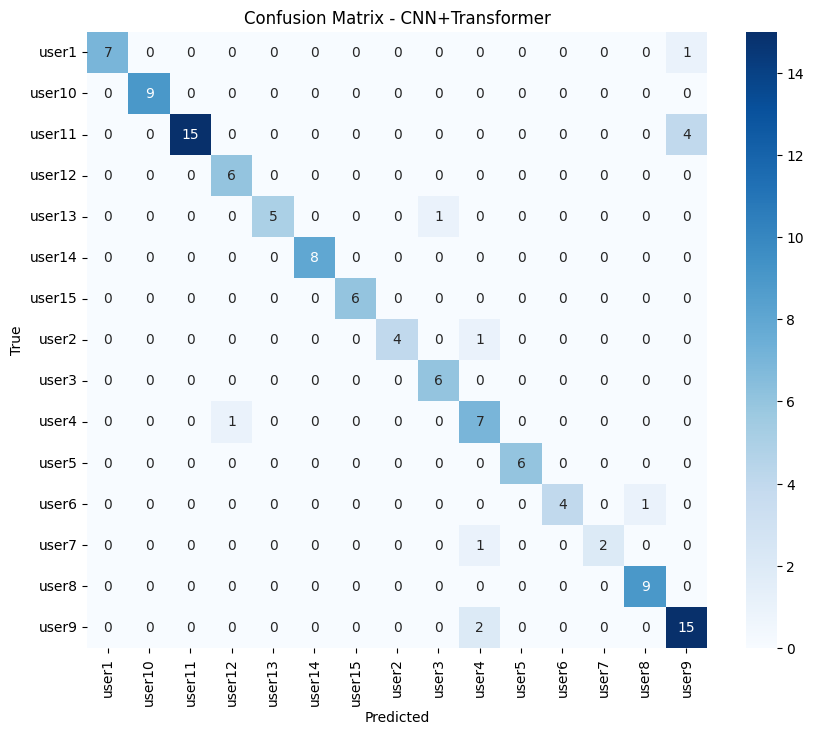

Classification Report - CNN+Transformer
              precision    recall  f1-score   support

       user1       1.00      0.88      0.93         8
      user10       1.00      1.00      1.00         9
      user11       1.00      0.79      0.88        19
      user12       0.86      1.00      0.92         6
      user13       1.00      0.83      0.91         6
      user14       1.00      1.00      1.00         8
      user15       1.00      1.00      1.00         6
       user2       1.00      0.80      0.89         5
       user3       0.86      1.00      0.92         6
       user4       0.64      0.88      0.74         8
       user5       1.00      1.00      1.00         6
       user6       1.00      0.80      0.89         5
       user7       1.00      0.67      0.80         3
       user8       0.90      1.00      0.95         9
       user9       0.75      0.88      0.81        17

    accuracy                           0.90       121
   macro avg       0.93      0.90      0

In [4]:
# Confusion matrix for CNN+Transformer with fixed class names
conf_matrix_cnn_transformer = confusion_matrix(y_test, y_pred_classes_cnn_transformer)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn_transformer, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN+Transformer')
plt.show()

# Classification report for CNN+Transformer
print("Classification Report - CNN+Transformer")
print(classification_report(y_test, y_pred_classes_cnn_transformer, target_names=label_encoder.classes_))

# Print model summary to see the number of parameters
model_cnn_transformer.summary()